In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import scipy.stats as stat

print("pandas version : ", pd.__version__)
print("xarray version : ", xr.__version__)

sns.set_style("whitegrid")
plt.rcParams["font.family"] = 'sans-serif'

('pandas version : ', u'0.23.4')
('xarray version : ', u'0.11.0')


### Test residual generation method by Farmer and Vogel 2016
https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016WR019129

1. Compute multiplicative residual R(t) = O(t)/S(t)
2. Sort S(t)
3. Compute empirical nonexceedance probablity p (e.g., weibull plotting position)
4. Split S and corresponding R into 10 group based on p
5. For each time step, randomely sample residual from a group that S(t) belong to

note:
vic streamflow is mm/day
mhm streamflow is m3/sec

In [2]:
# Getting Data: 
# 1. simulated streamflow from vic and mhm
# 2. Basin list file

data_path = './data'

# List of objective functions used
obj_fun_list = ['nse','kge']
# List of models used
model_list = ['vic', 'mhm']

# Read model deterministic simulated streamflow at daily steps
ds_vic_flow_all = xr.open_dataset('%s/results_hcdn_flow_vic_491.nc'%data_path)
ds_mhm_flow_all = xr.open_dataset('%s/results_hcdn_flow_mhm_491.nc'%data_path)

# Read basin attributes 
df_hcdn = pd.read_csv('%s/hcdn.calib.conus.491.list'%data_path, delim_whitespace=True,
                   header=None, names=['id', 'lat', 'lon', 'area'])    #area is sq-meters

hcdn = df_hcdn['id']
nbasin = len(df_hcdn['id'])
ndata = len(obj_fun_list)
nmodel = len(model_list)

# Print data variables
print('VIC flow data')
print('-------------')
print(ds_vic_flow_all)
print('\nmHM flow data')
print('-------------')
print(ds_mhm_flow_all)

VIC flow data
-------------
<xarray.Dataset>
Dimensions:      (hcdn: 491, time: 6940)
Coordinates:
  * hcdn         (hcdn) int64 1022500 1031500 1047000 ... 14362250 14400000
  * time         (time) datetime64[ns] 1989-10-01 1989-10-02 ... 2008-09-30
Data variables:
    nse          (hcdn, time) float32 ...
    kge          (hcdn, time) float32 ...
    kge_alpha    (hcdn, time) float32 ...
    kge_2alpha   (hcdn, time) float32 ...
    kge_5alpha   (hcdn, time) float32 ...
    kge_10alpha  (hcdn, time) float32 ...
    sig1         (hcdn, time) float32 ...
    obs          (hcdn, time) float32 ...

mHM flow data
-------------
<xarray.Dataset>
Dimensions:     (hcdn: 491, time: 6940)
Coordinates:
  * hcdn        (hcdn) int64 1022500 1031500 1047000 ... 14362250 14400000
  * time        (time) datetime64[ns] 1989-10-01 1989-10-02 ... 2008-09-30
Data variables:
    nse         (hcdn, time) float32 ...
    kge_2alpha  (hcdn, time) float32 ...
    kge         (hcdn, time) float32 ...
    sig1 

In [3]:
# Calibration period
ds_vic_flow_cal = ds_vic_flow_all.sel(time=slice('1999-10-01', '2008-09-30'))
ds_mhm_flow_cal = ds_mhm_flow_all.sel(time=slice('1999-10-01', '2008-09-30'))
ntime_cal = len(ds_vic_flow_cal['time'])

prob_cal=np.arange(1,float(ntime_cal+1))/(1+ntime_cal) #probability
for d in range(len(prob_cal)):
    idx50=d
    if prob_cal[d] > 0.5: break
for d in range(len(prob_cal)):
    idx30=d
    if prob_cal[d] > 0.3: break
for d in range(len(prob_cal)):
    idx80=d
    if prob_cal[d] > 0.8: break

In [4]:
# validation period
ds_vic_flow_val = ds_vic_flow_all.sel(time=slice('1989-10-01', '1999-09-30'))
ds_mhm_flow_val = ds_mhm_flow_all.sel(time=slice('1989-10-01', '1999-09-30'))
ntime_val = len(ds_vic_flow_val['time'])

prob_val=np.arange(1,float(ntime_val+1))/(1+ntime_val) #probability
for d in range(len(prob_val)):
    idx50=d
    if prob_val[d] > 0.5: break
for d in range(len(prob_val)):
    idx30=d
    if prob_val[d] > 0.3: break
for d in range(len(prob_val)):
    idx80=d
    if prob_val[d] > 0.8: break

In [5]:
# Personal functions used here.
def nse(qsim, qobs):
    return 1-np.sum((qsim-qobs)**2)/np.sum((qobs-np.mean(qobs))**2)

def corr(qsim, qobs):
    return np.corrcoef(qsim, qobs)[0, 1]
    
def alpha(qsim, qobs):
    return math.sqrt(np.sum((qsim-np.mean(qsim))**2)/len(qsim))/math.sqrt(np.sum((qobs-np.mean(qobs))**2)/len(qobs))
    
def beta(qsim, qobs):
    return np.mean(qsim)/np.mean(qobs)

def kge(qsim, qobs):
    return 1-math.sqrt((1-corr(qsim, qobs))**2 + (alpha(qsim, qobs)-1)**2 + (beta(qsim, qobs)-1)**2)

def pbias(qsim, qobs):
    return np.sum((qsim-qobs))/np.sum(qobs)

In [6]:
# generate model residuals stochastically
#Farmer and Vogel
def FV2016(sim, obs, nens):
    # sim:  1 dimension numpy array
    # obs:  1 dimension numpy array
    sim = np.where(sim>0.0, sim, 1.0e-7)
    obs = np.where(obs>0.0, obs, 1.0e-7)
    
    # compute ranked simulation (i.e., descending order) and nonexceedance probablity with weibull plotting position
    sim_ordered = np.sort(sim)
    index_ordered = np.argsort(sim)
    prob = np.arange(1,float(len(sim)+1))/(1+len(sim)) #probability
   
    # residual - ratio of sim to obs
    res = obs/sim
    res_ordered = res[index_ordered]

    # group simulation and residual into 10 groups defined by 10 equal nonexceedance probability range
    # 0: [0.0 0.1]
    # 1: [0.1 0.2]
    # .
    # .
    # 9: [0.9 1.0]
    # -----
    # grouping residual
    prange = np.arange(0.,1.01,0.01)
    res_grouped = {}
    sim_grouped = {}
    for idx in range(len(prange)-1):
        a = res_ordered[(prob >= prange[idx]) & (prob < prange[idx+1])]
        res_grouped[idx] = a
        sim_grouped[idx] = sim_ordered[(prob >= prange[idx]) & (prob < prange[idx+1])]
    #print(res_grouped)
    #print(sim_grouped)
    # make time series of group based on sim and probability
    cat = np.full(len(sim),-999, np.dtype('int32'))
    for idx, idx_ord in enumerate(index_ordered):
        cat[idx_ord] = int(np.floor(prob[idx]*100))

    # For each flow in each group, synthetic flow is generated 
    # by randomely selecting residual from the associated group
    q1 = np.full((len(sim),nens), -999.0)
    for iens in range(nens):
        for idx, q in enumerate(sim):
            res_one_group = res_grouped[cat[idx]]
            res_sampled = np.random.choice(res_one_group,1)
            q1[idx, iens] = q*res_sampled
            
    return q1

No handlers could be found for logger "matplotlib.legend"


Text(0,0.5,u'Q')

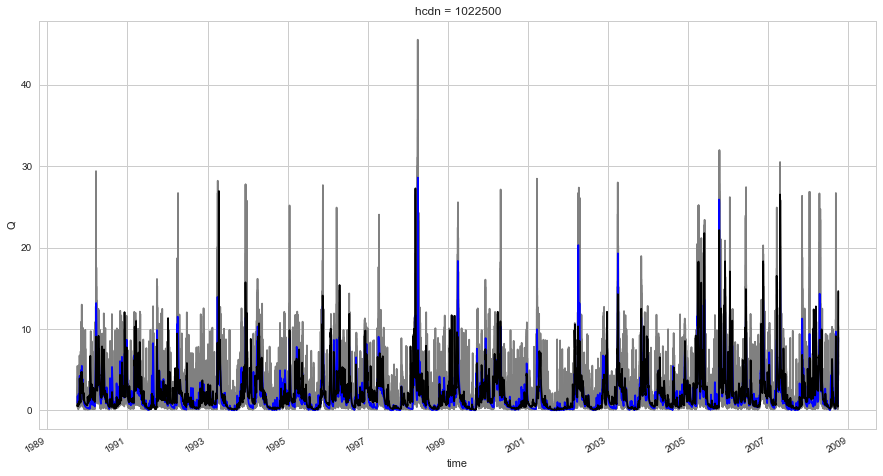

In [12]:
# test
hcdn = 1022500
sim=ds_vic_flow_all['kge'].sel(hcdn=hcdn)[0:]
obs=ds_vic_flow_all['obs'].sel(hcdn=hcdn)[0:]
q1 = FV2016(sim, obs, 10)

_, ax = plt.subplots(figsize=(15, 7.5))

ax.plot(ds_vic_flow_all['time'][0:],q1[0:,:], color='gray')
ds_vic_flow_all['kge'].sel(hcdn=hcdn)[0:].plot(ax = ax, color='blue')
ds_vic_flow_all['obs'].sel(hcdn=hcdn)[0:].plot(ax = ax, color='black')
ax.set_ylabel('Q')

Text(0.5,0,u'sim')

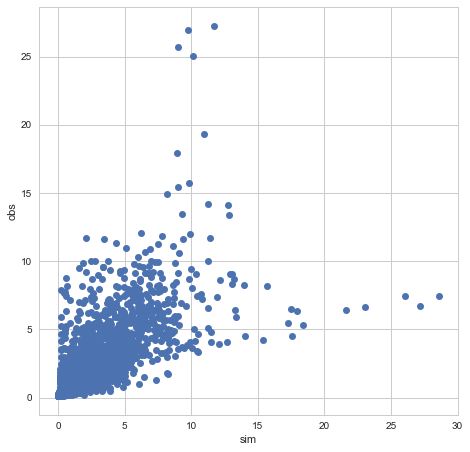

In [14]:
#plot scatter plots between obs and sim
_, ax = plt.subplots(figsize=(7.5, 7.5))
ax.plot(ds_vic_flow_all['kge'].sel(hcdn=hcdn)[0:365*10],ds_vic_flow_all['obs'].sel(hcdn=hcdn)[0:365*10], 'o')
ax.set_ylabel('obs')
ax.set_xlabel('sim')

Text(0,0.5,u'residual')

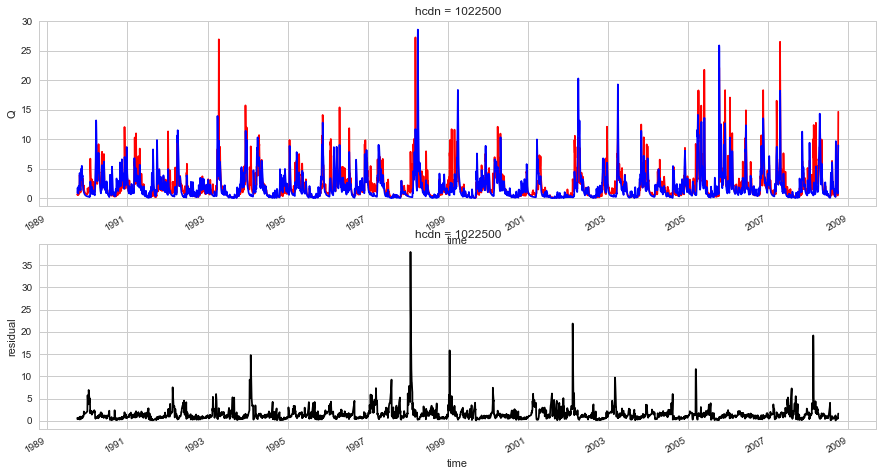

In [21]:
obs = ds_vic_flow_all['obs']
sim = ds_vic_flow_all['kge']
sim1 = sim.where(sim>0.0, 1.0e-7)
obs1 = obs.where(obs>0.0, 1.0e-7)
res = obs1/sim1
_, ax1 = plt.subplots(2,1, figsize=(15, 7.5))
obs.sel(hcdn=hcdn)[0:].plot(ax=ax1[0], color='red')
sim.sel(hcdn=hcdn)[0:].plot(ax=ax1[0], color='blue')
res.sel(hcdn=hcdn)[0:].plot(ax=ax1[1], color='black')
ax1[0].set_ylabel('Q')
ax1[1].set_ylabel('residual')